Done in this notebook:
- [X] plot the reconstruction
- [X] comparing pixels
  - [X] for each cell, compute 100 reconstructions
  - [X] compute the loss for each pixel averaging on the 100 reconstructions
- [X] comparing cells
  - [X] plot dataset level performance (the loss is the metric, or maybe the reconstruction)
- [X] comparing images

In [4]:
import os
import sys

os.chdir('/data/l989o/deployed/a')
if '/data/l989o/projects/a' in sys.path:
    sys.path.remove('/data/l989o/projects/a')

In [5]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'
from typing import Tuple, Set, List
from tqdm import tqdm
from pprint import pprint
import numpy as np
# import pl_bolts.utils
import torch
from torch.utils.data import DataLoader
from models.ae_conv_vae_lightning import VAE, RGBCells, COOL_CHANNELS
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.utils import make_grid
import PIL
import random
from torch import nn

In [6]:
# model_path = '/data/l989o/spatial_uzh/data/spatial_uzh_processed/a/checkpoints/resnet_vae/version_115/checkpoints'
model_path = '/data/l989o/data/basel_zurich/spatial_uzh_processed/a/checkpoints/resnet_vae/version_19/checkpoints'
l = os.listdir(model_path)
assert len(l) == 1
assert l[0].endswith('.ckpt')
l

['epoch=2-step=1230.ckpt']

In [7]:
checkpoint = os.path.join(model_path, l[0])
model = VAE.load_from_checkpoint(checkpoint)
model = model.cuda()
val_ds = RGBCells('validation')
val_loader = DataLoader(val_ds, batch_size=16, num_workers=8, pin_memory=True, shuffle=True)

In [8]:
quantiles_for_normalization = np.array([4.0549, 1.8684, 1.3117, 3.8141, 2.6172, 3.1571, 1.4984, 1.8866, 1.2621,
                                    3.7035, 3.6496, 1.8566, 2.5784, 0.9939, 1.4314, 2.1803, 1.8672, 1.6674,
                                    2.3555, 0.8917, 5.1779, 1.8002, 1.4042, 2.3873, 1.0509, 1.0892, 2.2708,
                                    3.4417, 1.8348, 1.8449, 2.8699, 2.2071, 1.0464, 2.5855, 2.0384, 4.8609,
                                    2.0277, 3.3281, 3.9273])[COOL_CHANNELS]

In [9]:
from models.ae_conv_vae_lightning import get_image
img, all_original_c, all_reconstructed_c, all_masks = get_image(val_loader, model, return_cells=True)

/data/l989o/deployed/a/models/ae_conv_vae_lightning.py:324: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  cm = autograd.detect_anomaly()


In [10]:
print(len(all_original_c))
print(len(all_reconstructed_c))
print(len(all_masks))
print(len(all_original_c[0]))

39
39
15
15


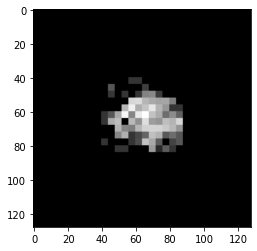

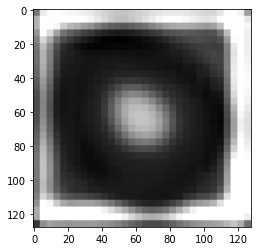

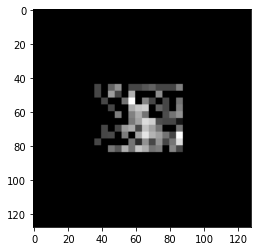

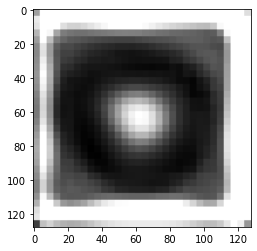

In [11]:
assert len(COOL_CHANNELS) == len(all_original_c)
all_p = torch.sigmoid(model.negative_binomial_p_logit)
for channel in range(len(COOL_CHANNELS)):
    p = all_p[channel]
    for i, mask in enumerate(all_masks):
        original = all_original_c[channel][i]
        reconstructed = all_reconstructed_c[channel][i]
        # gray scale image with repeated channels
        assert torch.all(original[0] == original[1])
        assert torch.all(original[0] == original[2])
        assert torch.all(reconstructed[0] == reconstructed[1])
        assert torch.all(reconstructed[0] == reconstructed[2])
        original = original[0]
        reconstructed = reconstructed[0]
        plt.figure()
        plt.imshow(original, cmap='gray')
        plt.show()
        
        plt.figure()
        plt.imshow(reconstructed, cmap='gray')
        plt.show()
                
        if i >= 1:
            break
    else:
        continue
    break

In [12]:
n = 15

mask_color = torch.tensor([x / 255 for x in [254, 112, 31]]).float()
new_size = (128, 128)
upscale = transforms.Resize(new_size, interpolation=PIL.Image.NEAREST)
n = 15
with torch.no_grad():
    batch = val_loader.__iter__().__next__()
    omes = batch[0]
    masks = batch[1]
    assert len(omes.shape) == 4
    assert len(omes) >= n
    data = omes[:n].to(model.device)
    masks_data = masks[:n].to(model.device)
    pred = model.forward(data, masks_data)[0]
n_channels = data.shape[1]

/data/l989o/deployed/a/models/ae_conv_vae_lightning.py:324: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  cm = autograd.detect_anomaly()


In [13]:
x = np.zeros((3, 3, 3))
y = np.ones((3, 3), dtype=np.bool)
y[1, 1] = 0
print(y)
x[y, :] = 2
x

[[ True  True  True]
 [ True False  True]
 [ True  True  True]]


array([[[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]],

       [[2., 2., 2.],
        [0., 0., 0.],
        [2., 2., 2.]],

       [[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]]])

In [14]:
x = torch.zeros(3, 3, 3)
y = torch.ones(3, 3, dtype=torch.bool)
y[1, 1] = 0
print(y)
x[y, :] = 2
x

tensor([[ True,  True,  True],
        [ True, False,  True],
        [ True,  True,  True]])


tensor([[[2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.]],

        [[2., 2., 2.],
         [0., 0., 0.],
         [2., 2., 2.]],

        [[2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.]]])

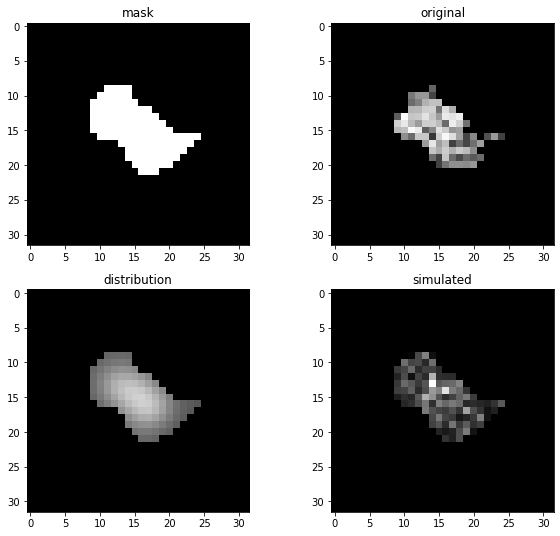

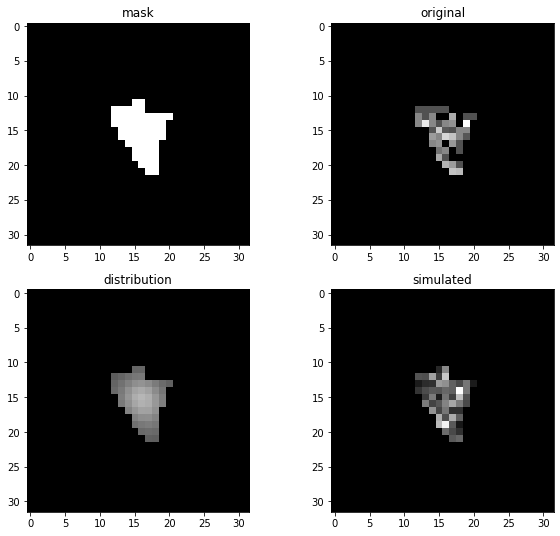

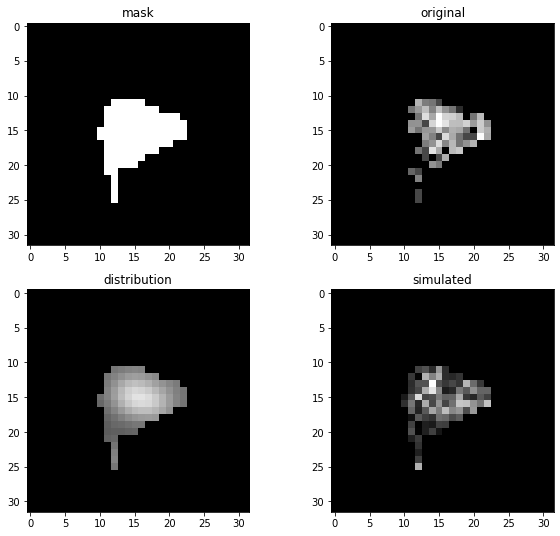

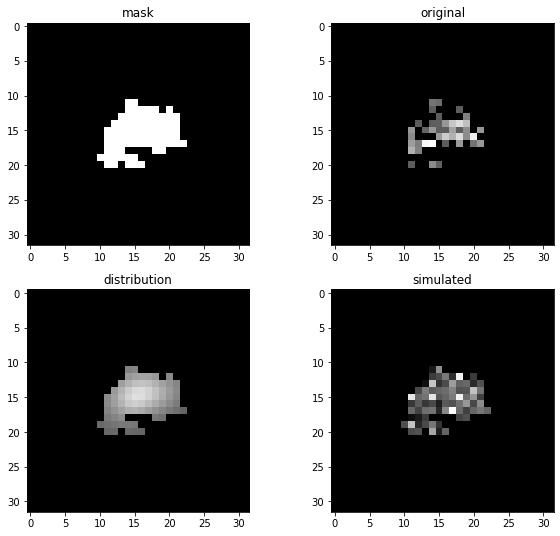

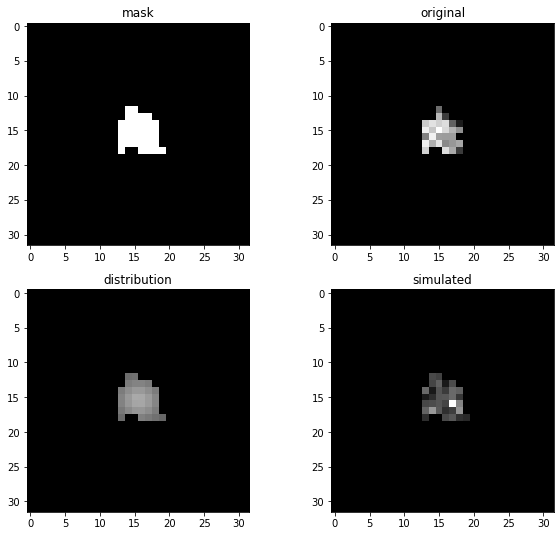

In [15]:
for i in range(5):
    c = 0

    original = data[i].cpu().permute(1, 2, 0) * quantiles_for_normalization
    r_hat = pred[i].cpu().permute(1, 2, 0)
    p = torch.sigmoid(model.negative_binomial_p_logit).cpu().detach()
    mean = model.negative_binomial_mean(r=r_hat, p=p)
    reconstructed = mean * quantiles_for_normalization

    a_original = original.amin(dim=(0, 1))
    b_original = original.amax(dim=(0, 1))
    m = masks_data[i].cpu().bool()
    mm = torch.squeeze(m, 0)
    mm_not = torch.logical_not(mm)
    reconstructed_flattened = torch.reshape(reconstructed, (-1, reconstructed.shape[-1]))
    mask_flattened = mm.flatten()
    if mask_flattened.sum() > 0:
        a_reconstructed = reconstructed_flattened[mask_flattened, :].amin(dim=0)
        b_reconstructed = reconstructed_flattened[mask_flattened, :].amax(dim=0)
        a = torch.min(a_original, a_reconstructed)
        b = torch.max(b_original, b_reconstructed)

        original = ((original - a) / (b - a)).float()
        reconstructed = ((reconstructed - a) / (b - a)).float()

        axes = plt.subplots(2, 2, figsize=(10, 9))[1].flatten()
        axes[0].imshow(mm, cmap='gray')
        axes[0].set(title='mask')
        
        original[mm_not, :] = 0
        axes[1].imshow(original[:, :, c], cmap='gray')
        axes[1].set(title='original')
        max_original = original.max()
        
        reconstructed[mm_not, :] = 0
        axes[2].imshow(reconstructed[:, :, c], cmap='gray', vmax=max_original)
        axes[2].set(title='distribution')
        
        x0 = r_hat[:, :, c].numpy()
        x1 = p[c].repeat(1024).reshape(32, 32).numpy()
        assert x0.shape == x1.shape
        assert x0.shape == (32, 32)
        from scipy.stats import nbinom
        # THERE IS A BUG HEREEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
        # THERE IS A BUG HEREEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
        # THERE IS A BUG HEREEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
        # THERE IS A BUG HEREEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
        # THERE IS A BUG HEREEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
        # THERE IS A BUG HEREEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE the range of x is wrong (set vmax and see)
        x = nbinom.rvs(x0, x1, size=(32, 32))  # * quantiles_for_normalization[c]
        x[mm_not.numpy()] = 0
        axes[3].imshow(x, cmap='gray')#, vmax=max_original)
        axes[3].set(title='simulated')
        plt.show()
    else:
        print('empty mask')

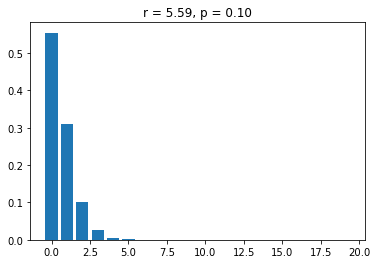

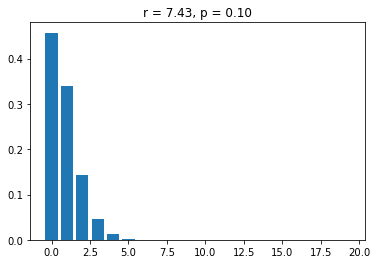

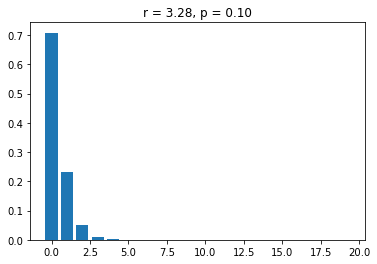

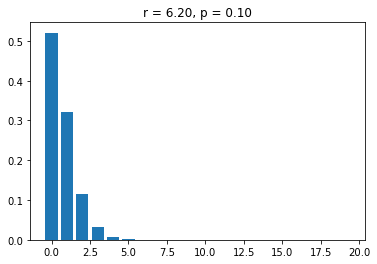

In [16]:
for i in [0, 23, 234, 1000]:
    def nb_probs(r, p, k):
        return torch.exp(torch.lgamma(k + r) - torch.lgamma(k + 1) - torch.lgamma(r) + r * torch.log(1 - p) + k * torch.log(p))
    r = torch.tensor(x0.flatten()[i]).repeat(20)
    p = torch.tensor(x1.flatten()[i]).repeat(20)
    k = torch.tensor(range(20)).float()
    probs = nb_probs(r, p, k)
    plt.bar(k, probs)
    plt.title(f'r = {r[0]:.02f}, p = {p[0]:.02f}')
    plt.show()

In [17]:
train_ds = RGBCells('train')
val_ds = RGBCells('validation')
train_loader = DataLoader(train_ds, batch_size=512, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=512, num_workers=8, pin_memory=True)

# metrics for pixels, one cell

In [18]:
from tqdm import tqdm

quantiles = quantiles_for_normalization
loader = val_loader
first_batch = loader.__iter__().__next__()
cell_index = 10
first_cell, first_mask = first_batch[0][cell_index], first_batch[1][cell_index]
print(first_cell.shape)
print(first_mask.shape)

torch.Size([39, 32, 32])
torch.Size([1, 32, 32])


In [19]:
cell_clones = torch.stack([first_cell] * 128, dim=0).cuda()
mask_clones = torch.stack([first_mask] * 128, dim=0).cuda()

In [20]:
with torch.no_grad():
    pred, mu, std, z = model.forward(cell_clones, mask_clones)
    elbo, kl, recon_loss = model.loss_function(cell_clones, pred, mu, std, z, mask_clones)
    r = pred
    p = model.boosted_sigmoid(model.negative_binomial_p_logit)
    log_pxz = model.negative_binomial_log_prob(r, p, k=cell_clones)
    s = (mask_clones * log_pxz).mean(dim=(0))

torch.Size([128, 39, 32, 32])
torch.Size([39, 32, 32])


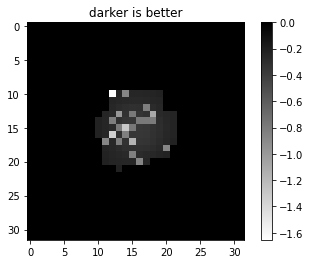

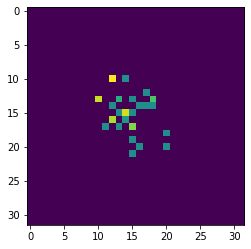

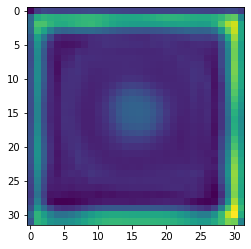

In [23]:
print(log_pxz.shape)
print(s.shape)
c = 1
ss = s.cpu().numpy()
plt.imshow(np.log(-ss[c, :, :] + 0.00001), cmap='gray')
plt.imshow(ss[c, :, :], cmap='gray_r')
plt.title('darker is better')
plt.colorbar()
plt.show()
plt.imshow(cell_clones[0, c, :, :].cpu().numpy())
plt.show()
plt.imshow(pred[0, c, :, :].cpu().numpy())
plt.show()

tensor(0.6889, device='cuda:0')
torch.Size([]) torch.Size([128]) torch.Size([128])


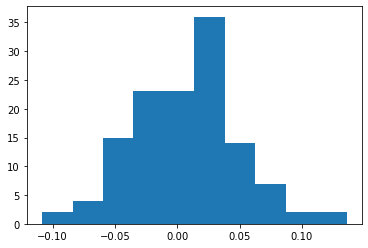

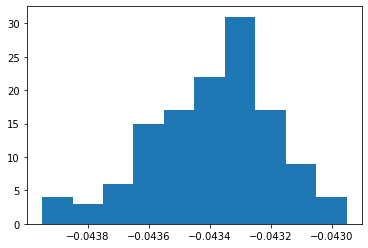

In [93]:
print(elbo)
print(elbo.shape, kl.shape, recon_loss.shape)
plt.hist(kl.cpu().numpy())
plt.show()
plt.hist(recon_loss.cpu().numpy())
plt.show()

In [94]:
for i in range(5):
    print(pred[i, 0, :3, :3].flatten().cpu().numpy().tolist())
#     plt.imshow(pred[i, 0, :, :].cpu().numpy())
#     plt.show()

[5.46906852722168, 8.547718048095703, 8.779501914978027, 6.857418060302734, 10.204462051391602, 10.127492904663086, 6.769088268280029, 9.71909236907959, 8.973456382751465]
[5.5933051109313965, 8.7424955368042, 9.00955867767334, 7.008554458618164, 10.458555221557617, 10.442460060119629, 6.907625198364258, 9.903875350952148, 9.206778526306152]
[5.446953773498535, 8.511528015136719, 8.748658180236816, 6.824724197387695, 10.139017105102539, 10.075522422790527, 6.744314670562744, 9.634971618652344, 8.899803161621094]
[5.503511428833008, 8.588595390319824, 8.828611373901367, 6.9020843505859375, 10.258720397949219, 10.196078300476074, 6.813830852508545, 9.752873420715332, 9.010282516479492]
[5.5435099601745605, 8.662500381469727, 8.900413513183594, 6.955523490905762, 10.341817855834961, 10.299419403076172, 6.841242790222168, 9.79838752746582, 9.069221496582031]


# metrics for cells, one image

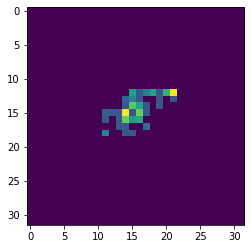

In [19]:
from data2 import IndexInfo

ii = IndexInfo('validation')
a = val_loader.__iter__().__next__()
a[0][0].shape
plt.imshow(a[0][0][0])

In [20]:
begin = ii.filtered_begins[0]
end = ii.filtered_ends[0]
# print(begin, end)

elbos = []
reconstructions = []
kls = []
n = 0

pbar = tqdm(total=end)
for batch in val_loader:
    omes, masks = batch
    m = len(omes)
    if n + m > end:
        m = end - n
    omes = omes[:m]
    masks = masks[:m]
    
    for ome, mask in zip(omes, masks):
        with torch.no_grad():
            cell_clones = torch.stack([ome] * 128, dim=0).cuda()
            mask_clones = torch.stack([mask] * 128, dim=0).cuda()
            pred, mu, std, z = model.forward(cell_clones, mask_clones)
            elbo, kl, recon_loss = model.loss_function(cell_clones, pred, mu, std, z, mask_clones)
            elbos.append(elbo)
            reconstructions.append(recon_loss)
            kls.append(kl)
#             r = pred
#             p = model.boosted_sigmoid(model.negative_binomial_p_logit)
#             log_pxz = model.negative_binomial_log_prob(r, p, k=cell_clones)
#             s = (mask_clones * log_pxz).mean(dim=(0))    
    n += m
    pbar.update(m)
    if n == end:
        break
pbar.close()

100%|██████████| 1793/1793 [00:53<00:00, 33.67it/s]


In [21]:
elbos = torch.stack(elbos).cpu().numpy()
reconstructions = torch.stack(reconstructions).mean(1).cpu().numpy()
kls = torch.stack(kls).cpu().mean(1).numpy()

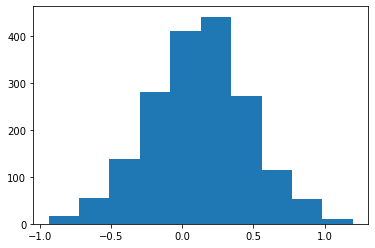

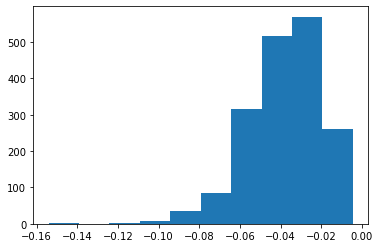

(array([ 22.,  56., 140., 289., 400., 432., 277., 111.,  56.,  10.]),
 array([-0.00953558, -0.00744238, -0.00534918, -0.00325598, -0.00116278,
         0.00093042,  0.00302362,  0.00511682,  0.00721002,  0.00930322,
         0.01139642], dtype=float32),
 <BarContainer object of 10 artists>)

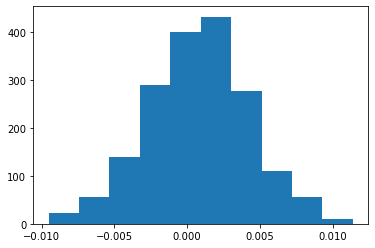

In [22]:
plt.hist(elbos)
plt.show()
plt.hist(reconstructions)
plt.show()
plt.hist(kls)

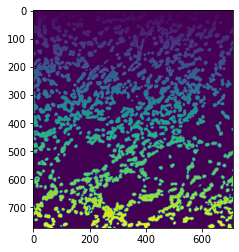

In [23]:
from data2 import OmeDataset, FilteredMasksRelabeled
ome_dataset = OmeDataset('validation')
ome = ome_dataset[0]
masks_dataset = FilteredMasksRelabeled('validation')
masks = masks_dataset[0]

plt.imshow(masks)

In [24]:
print(masks.max())
print(len(elbos))

1793
1793


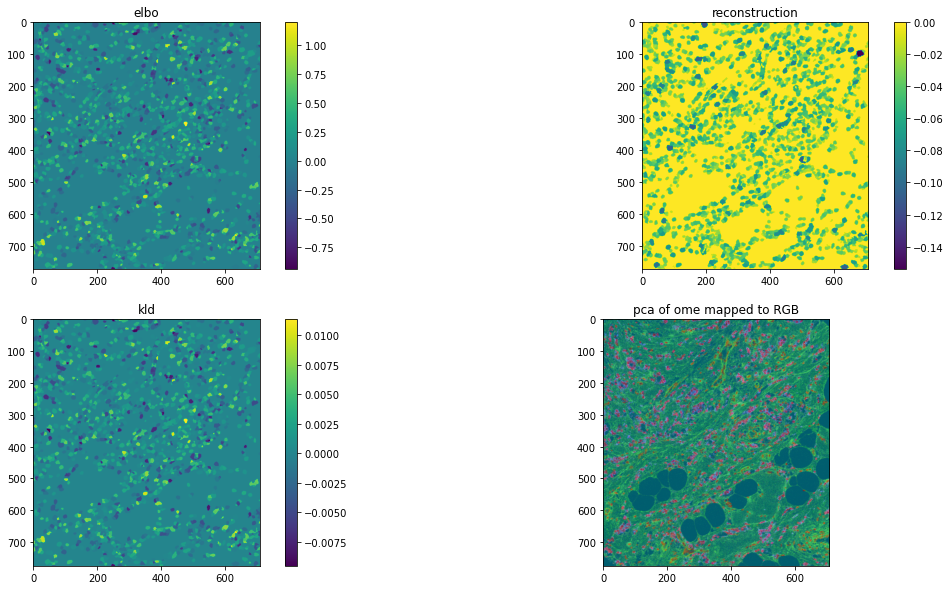

In [25]:
elbos_with_background = np.insert(elbos, 0, 0.)
reconstructions_with_background = np.insert(reconstructions, 0, 0.)
kls_with_background = np.insert(kls, 0, 0.)
axes = plt.subplots(2, 2, figsize=(20, 10))[1].flatten()

im = axes[0].imshow(elbos_with_background[masks])
plt.colorbar(im, ax=axes[0])
axes[0].set(title='elbo')

im = axes[1].imshow(reconstructions_with_background[masks])
plt.colorbar(im, ax=axes[1])
axes[1].set(title='reconstruction')

im = axes[2].imshow(kls_with_background[masks])
plt.colorbar(im, ax=axes[2])
axes[2].set(title='kld')

from sklearn.decomposition import PCA
pca_shape = (ome.shape[0], ome.shape[1], 3)
pca = PCA(3).fit_transform(np.arcsinh(ome).reshape(-1, ome.shape[-1]))
pca = (pca - pca.min(0)) / (pca.max(0) - pca.min(0))
axes[3].imshow(pca.reshape(pca_shape))
axes[3].set(title='pca of ome mapped to RGB')
plt.show()

# metrics for channels and images, many images

In [26]:
begins = ii.filtered_begins
ends = ii.filtered_ends
# print(begin, end)

elbos = []
reconstructions = []
kls = []
n = 0
n_images = len(begins) - 1
max_n = ends[n_images]

In [21]:
pbar = tqdm(total=max_n)
for batch in val_loader:
    omes, masks = batch
    m = len(omes)
    if n + m > max_n:
        m = max_n - n
    omes = omes[:m]
    masks = masks[:m]
    
    for ome, mask in zip(omes, masks):
        with torch.no_grad():
            cell_clones = torch.stack([ome] * 16, dim=0).cuda()
            mask_clones = torch.stack([mask] * 16, dim=0).cuda()
            pred, mu, std, z = model.forward(cell_clones, mask_clones)
            elbo, kl, recon_loss = model.loss_function(cell_clones, pred, mu, std, z, mask_clones)
            elbos.append(elbo)
#             reconstructions.append(recon_loss)
            kls.append(kl.mean())
            r = pred
            p = model.boosted_sigmoid(model.negative_binomial_p_logit)
            log_pxz = model.negative_binomial_log_prob(r, p, k=cell_clones)
            per_channel_reconstruction = (mask_clones * log_pxz).mean(dim=(0, 2, 3))
            reconstructions.append(per_channel_reconstruction)
    n += m
    pbar.update(m)
    if n == max_n:
        break
pbar.close()

NameError: name 'ii' is not defined

In [27]:
elboss = torch.stack(elbos).cpu().numpy()
klss = torch.stack(kls).cpu().numpy()
reconss = torch.stack(reconstructions).cpu().numpy()

RuntimeError: stack expects a non-empty TensorList

In [ ]:
import pickle
pickle.dump((elboss, klss, reconss), open('/data/l989o/temp/a', 'wb'))

In [28]:
import pickle
elboss, klss, reconss = pickle.load(open('/data/l989o/temp/a', 'rb'))

torch.Size([112, 39])


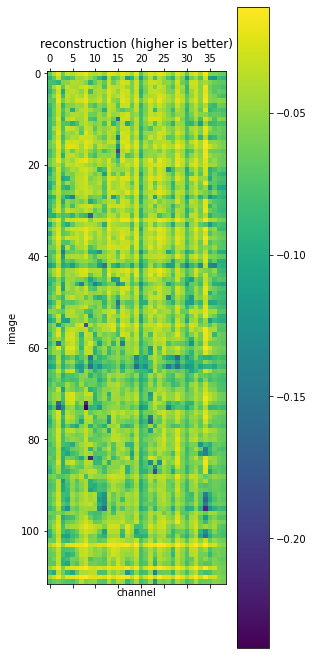

In [32]:
l = []
for begin, end in zip(begins[:n_images], ends[:n_images]):
    r = reconss[begin: end].mean(0)
    l.append(r)
m = torch.tensor(l)
print(m.shape)

plt.matshow(m.numpy())
plt.xlabel('channel')
plt.ylabel('image')
plt.title('reconstruction (higher is better)')
plt.colorbar()

torch.Size([112, 1])


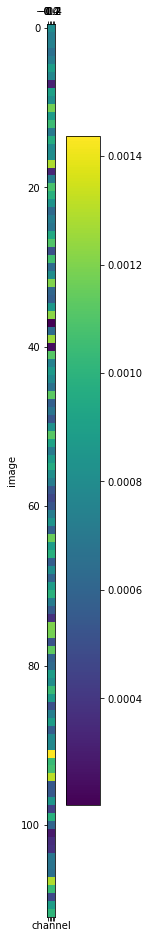

In [57]:
l = []
for begin, end in zip(begins[:n_images], ends[:n_images]):
    r = klss[begin: end]
    l.append(r.mean(0))
m = torch.tensor(l).reshape(-1, 1)
print(m.shape)

plt.matshow(m.cpu().numpy())
plt.xlabel('channel')
plt.ylabel('image')
plt.colorbar()

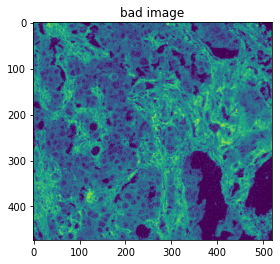

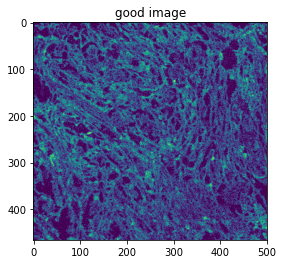

In [62]:
bad_image = 101
good_image = 103
plt.imshow(np.arcsinh(ome_dataset[bad_image][:, :, 20]))
plt.title('bad image')
plt.show()
plt.imshow(np.arcsinh(ome_dataset[good_image][:, :, 20]))
plt.title('good image')
plt.show()